## Following procedure found in "VAE synthetic generation.ipynb", refer to that for more information

In [12]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
import random

syn_data = pd.read_csv('cvae_safe_top27_200k.csv')
real_data = pd.read_csv('real_train_ctgan_200k_safe27.csv')

syn_data_sub = syn_data.sample(n=120000, random_state=42)
real_data_sub = real_data.sample(n=120000, random_state=42)

syn_data_sub_train = syn_data_sub.iloc[:100000]
syn_data_sub_val = syn_data_sub.iloc[100000:]
real_data_sub_train = real_data_sub.iloc[:100000]
real_data_sub_val = real_data_sub.iloc[100000:]


trainers = [real_data_sub_train, syn_data_sub_train]
valid = [real_data_sub_val, syn_data_sub_val]

mixed_train = pd.concat(trainers)
mixed_val = pd.concat(valid)

print(mixed_train.shape)
print(mixed_val.shape)

(200000, 28)
(40000, 28)


In [8]:
X_mixed_train = mixed_train.drop('label', axis=1)
y_mixed_train = mixed_train['label'].astype(int)
X_mixed_val = mixed_val.drop('label', axis=1)
y_mixed_val = mixed_val['label'].astype(int)

scaler_cvae = MinMaxScaler()
scaler_cvae.fit(X_mixed_train)

X_mixed_train_cvae = scaler_cvae.transform(X_mixed_train)
X_mixed_val_cvae = scaler_cvae.transform(X_mixed_val)

with open("cvaev2_safe27_scaler.pkl", "wb") as f:
    pickle.dump(scaler_cvae, f)

print("Saved scaler -> cvaev2_safe27_scaler.pkl")

X_mixed_train_cvae = X_mixed_train_cvae.astype("float32")
X_mixed_val_cvae = X_mixed_val_cvae.astype("float32")

y_mixed_train_arr = y_mixed_train.astype("float32").values.reshape(-1, 1)
y_mixed_val_arr = y_mixed_val.astype("float32").values.reshape(-1, 1)

x_dim      = X_mixed_train_cvae.shape[1]  # 27
cond_dim   = 1                           # label y
input_dim  = x_dim + cond_dim           # encoder input: [x, y]
latent_dim = 16
hidden_dim = 64

devicev2 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", devicev2)

x_train_tensorv2 = torch.from_numpy(X_mixed_train_cvae).to(devicev2)
x_val_tensorv2 = torch.from_numpy(X_mixed_val_cvae).to(devicev2)

y_train_tensorv2 = torch.from_numpy(y_mixed_train_arr).to(devicev2)
y_val_tensorv2 = torch.from_numpy(y_mixed_val_arr).to(devicev2)

class CVAE(nn.Module):
    def __init__(self, x_dim, cond_dim, hidden_dim, latent_dim):
        super(CVAE, self).__init__()

        enc_input_dim = x_dim + cond_dim    # [x, y]
        dec_input_dim = latent_dim + cond_dim  # [z, y]

        # ----- Encoder -----
        self.encoder = nn.Sequential(
            nn.Linear(enc_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.fc_mu     = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # ----- Decoder -----
        self.decoder = nn.Sequential(
            nn.Linear(dec_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, x_dim),
            nn.Sigmoid(),  # outputs in [0, 1] to match MinMax-scaled features
        )

    def encode(self, x, y):
        # x: (batch, x_dim), y: (batch, 1)
        enc_input = torch.cat([x, y], dim=1)
        h = self.encoder(enc_input)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        # z: (batch, latent_dim), y: (batch, 1)
        dec_input = torch.cat([z, y], dim=1)
        x_recon = self.decoder(dec_input)
        return x_recon

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, y)
        return x_recon, mu, logvar

cvae = CVAE(
    x_dim=x_dim,
    cond_dim=cond_dim,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
).to(devicev2)

print(cvae)

Saved scaler -> cvaev2_safe27_scaler.pkl
Using device: cuda
CVAE(
  (encoder): Sequential(
    (0): Linear(in_features=28, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=64, out_features=16, bias=True)
  (fc_logvar): Linear(in_features=64, out_features=16, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=17, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=27, bias=True)
    (5): Sigmoid()
  )
)


In [9]:
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

batch_size = 1024

train_loader = DataLoader(
    TensorDataset(x_train_tensorv2, y_train_tensorv2),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

val_loader = DataLoader(
    TensorDataset(x_val_tensorv2, y_val_tensorv2),
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
)

# 4) CVAE loss: reconstruction + KL divergence
def cvae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    # Reconstruction loss over all dimensions (MSE)
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction="mean")
    # KL divergence between q(z|x,y) and N(0, I)
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kld, recon_loss, kld

# 5) Optimizer
learning_rate = 1e-3
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

# 6) Training loop
num_epochs = 10

cvae.train()
for epoch in range(1, num_epochs + 1):
    # ----- training -----
    train_loss_sum = 0.0
    train_recon_sum = 0.0
    train_kld_sum = 0.0
    n_train_batches = 0

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(devicev2)
        batch_y = batch_y.to(devicev2)

        optimizer.zero_grad()
        recon_x, mu, logvar = cvae(batch_x, batch_y)
        loss, recon_loss, kld = cvae_loss_function(recon_x, batch_x, mu, logvar)
        loss.backward()
        optimizer.step()

        train_loss_sum  += loss.item()
        train_recon_sum += recon_loss.item()
        train_kld_sum   += kld.item()
        n_train_batches += 1

    avg_train_loss  = train_loss_sum  / n_train_batches
    avg_train_recon = train_recon_sum / n_train_batches
    avg_train_kld   = train_kld_sum   / n_train_batches

    # ----- validation -----
    cvae.eval()
    with torch.no_grad():
        val_loss_sum = 0.0
        val_recon_sum = 0.0
        val_kld_sum = 0.0
        n_val_batches = 0

        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(devicev2)
            batch_y = batch_y.to(devicev2)

            recon_x, mu, logvar = cvae(batch_x, batch_y)
            loss, recon_loss, kld = cvae_loss_function(recon_x, batch_x, mu, logvar)

            val_loss_sum  += loss.item()
            val_recon_sum += recon_loss.item()
            val_kld_sum   += kld.item()
            n_val_batches += 1

    avg_val_loss  = val_loss_sum  / n_val_batches
    avg_val_recon = val_recon_sum / n_val_batches
    avg_val_kld   = val_kld_sum   / n_val_batches

    cvae.train()

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={avg_train_loss:.4f} "
        f"(recon={avg_train_recon:.4f}, kld={avg_train_kld:.4f}) | "
        f"val_loss={avg_val_loss:.4f} "
        f"(recon={avg_val_recon:.4f}, kld={avg_val_kld:.4f})"
    )

print("CVAE V2 training finished.")

Epoch 01 | train_loss=0.0382 (recon=0.0379, kld=0.0003) | val_loss=0.0275 (recon=0.0275, kld=0.0000)
Epoch 02 | train_loss=0.0280 (recon=0.0280, kld=0.0000) | val_loss=0.0272 (recon=0.0272, kld=0.0000)
Epoch 03 | train_loss=0.0278 (recon=0.0278, kld=0.0000) | val_loss=0.0271 (recon=0.0271, kld=0.0000)
Epoch 04 | train_loss=0.0277 (recon=0.0276, kld=0.0000) | val_loss=0.0269 (recon=0.0269, kld=0.0000)
Epoch 05 | train_loss=0.0275 (recon=0.0275, kld=0.0000) | val_loss=0.0267 (recon=0.0267, kld=0.0000)
Epoch 06 | train_loss=0.0274 (recon=0.0274, kld=0.0000) | val_loss=0.0267 (recon=0.0267, kld=0.0000)
Epoch 07 | train_loss=0.0273 (recon=0.0273, kld=0.0000) | val_loss=0.0267 (recon=0.0267, kld=0.0000)
Epoch 08 | train_loss=0.0273 (recon=0.0273, kld=0.0000) | val_loss=0.0267 (recon=0.0267, kld=0.0000)
Epoch 09 | train_loss=0.0273 (recon=0.0273, kld=0.0000) | val_loss=0.0266 (recon=0.0266, kld=0.0000)
Epoch 10 | train_loss=0.0273 (recon=0.0273, kld=0.0000) | val_loss=0.0266 (recon=0.0266, kl

In [10]:
import os

N_SYNTH_CVAE = 200_000
latent_dim = 16           # must match the definition in Section 8.2
x_dim = x_dim

print(f"Generating {N_SYNTH_CVAE:,} synthetic rows with CVAE...")

# 3) Estimate real CTR from the training split
real_ctrv2 = float(y_mixed_train.mean())
print(f"Real CTR (train split) ≈ {real_ctrv2:.5f}")

y_mixed_syn_np = np.random.binomial(1, real_ctrv2, size=N_SYNTH_CVAE).astype("float32")
y_mixed_tensor = torch.from_numpy(y_mixed_syn_np.reshape(-1, 1)).to(devicev2)

cvae.eval()
with torch.no_grad():
    z = torch.randn(N_SYNTH_CVAE, latent_dim, device=devicev2)

    # 6) Decode to scaled feature space given (z, y_syn)
    x_scaled = cvae.decode(z, y_mixed_tensor)  # shape: (N_SYNTH_CVAE, 27)
    x_scaled = x_scaled.clamp(0.0, 1.0)      # ensure within [0, 1]
    x_scaled_np = x_scaled.cpu().numpy()

print("Scaled feature matrix shape:", x_scaled_np.shape)

# 7) Inverse-transform to original feature space
X_cvae_mixed_syn = scaler_cvae.inverse_transform(x_scaled_np)
print("Inverse-transformed feature matrix shape:", X_cvae_mixed_syn.shape)

# 8) Build DataFrame with Safe Top-27 feature names
df_cvae_mixed_syn = pd.DataFrame(X_cvae_mixed_syn, columns=X_mixed_train.columns)

# 9) Attach the synthetic labels (already sampled above)
df_cvae_mixed_syn["label"] = y_mixed_syn_np.astype(int)

print("df_cvae_syn shape:", df_cvae_mixed_syn.shape)
print("Synthetic CTR (label=1):", df_cvae_mixed_syn["label"].mean())

# 10) Ensure output folder exists
os.makedirs("synthetic", exist_ok=True)

parquet_path = "synthetic/cvae_mixed_safe_top27_200k.parquet"
csv_path     = "synthetic/cvae_mixed_safe_top27_200k.csv"

df_cvae_mixed_syn.to_parquet(parquet_path, index=False)
df_cvae_mixed_syn.to_csv(csv_path, index=False)

print("Saved CVAE synthetic table ->", parquet_path)
print("Saved CVAE synthetic CSV   ->", csv_path)

Generating 200,000 synthetic rows with CVAE...
Real CTR (train split) ≈ 0.01564
Scaled feature matrix shape: (200000, 27)
Inverse-transformed feature matrix shape: (200000, 27)
df_cvae_syn shape: (200000, 28)
Synthetic CTR (label=1): 0.01617
Saved CVAE synthetic table -> synthetic/cvae_mixed_safe_top27_200k.parquet
Saved CVAE synthetic CSV   -> synthetic/cvae_mixed_safe_top27_200k.csv


In [16]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import (
    roc_auc_score, average_precision_score, log_loss,
    accuracy_score, precision_score, recall_score, f1_score
)

# 2) Load CVAE synthetic 200k table
cvae_mixed_path = "synthetic/cvae_mixed_safe_top27_200k.parquet"
df_cvae_mixed_200k = pd.read_parquet(cvae_mixed_path)

print("[8.5] Loaded df_cvae_syn_200k:", df_cvae_mixed_200k.shape)
print("[8.5] CVAE synthetic CTR:", df_cvae_mixed_200k["label"].mean())

# 3) Build training set from CVAE synthetic data (Safe Top-27 only)
X_train_cvae_mixed = df_cvae_mixed_200k.drop('label', axis=1).copy()
y_train_cvae_mixed = df_cvae_mixed_200k["label"].astype(int).copy()

print("[8.5] X_train_cvae shape:", X_train_cvae_mixed.shape)
print("[8.5] y_train_cvae mean:", y_train_cvae_mixed.mean())

# 4) Real validation set (same as before, Safe Top-27 only)
X_valid_cvae_mixed = X_mixed_val.copy()
y_valid_cvae_mixed = y_mixed_val.astype(int).copy()

print("[8.5] X_valid_real_cvae shape:", X_valid_cvae_mixed.shape)
print("[8.5] y_valid_real_cvae mean:", y_valid_cvae_mixed.mean())

base_lgb_params_cvae = {
    "objective": "binary",
    "metric": ["auc", "average_precision"],
    "learning_rate": 0.08,
    "num_leaves": 127,
    "max_depth": -1,
    "min_child_samples": 100,
    "subsample": 0.8,
    "subsample_freq": 1,
    "colsample_bytree": 0.8,
    "lambda_l2": 1.0,
    "n_jobs": -1,
    "seed": 42,
}

# Handle class imbalance using scale_pos_weight from synthetic CTR
pos_rate_cvae_mixed = y_train_cvae_mixed.mean()
scale_pos_weight_cvae_mixed = (1 - pos_rate_cvae_mixed) / pos_rate_cvae_mixed
base_lgb_params_cvae["scale_pos_weight"] = scale_pos_weight_cvae_mixed

print(f"scale_pos_weight (CVAE synthetic 200k) = {scale_pos_weight_cvae_mixed:.2f}")

# 6) Build LightGBM datasets
dtrain_cvae_mixed = lgb.Dataset(X_train_cvae_mixed, label=y_train_cvae_mixed)
dvalid_cvae_mixed = lgb.Dataset(X_valid_cvae_mixed, label=y_valid_cvae_mixed,
                          reference=dtrain_cvae_mixed)

print("Training LightGBM on 200k CVAE synthetic rows ...")
model_cvae_mixed_200k = lgb.train(
    params=base_lgb_params_cvae,
    train_set=dtrain_cvae_mixed,
    num_boost_round=2000,
    valid_sets=[dtrain_cvae_mixed, dvalid_cvae_mixed],
    valid_names=["train_cvae_mixed", "valid_cvae_mixed"],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100),
    ],
)

# 8) Predict on the real validation set
y_prob_cvae_mixed2real = model_cvae_mixed_200k.predict(
    X_valid_cvae_mixed,
    num_iteration=model_cvae_mixed_200k.best_iteration,
)

def eval_cvae_mixed2real(y_true, y_proba, threshold=0.5,
                       title="CVAE mixed → real"):
    y_pred = (y_proba >= threshold).astype(int)
    metrics = {
        "ROC-AUC": roc_auc_score(y_true, y_proba),
        "PR-AUC": average_precision_score(y_true, y_proba),
        "LogLoss": log_loss(y_true, y_proba),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
    }
    print(f"\n=== {title} @ threshold={threshold:.2f} ===")
    for k, v in metrics.items():
        print(f"{k:<10s}: {v:.4f}")
    return metrics

# 10) Compute and store metrics
metrics_cvae_mixed200k = eval_cvae_mixed2real(
    y_valid_cvae_mixed,
    y_prob_cvae_mixed2real,
    threshold=0.50,
    title="LightGBM (Train: 200k CVAE SYN, Test: REAL valid)",
)


[8.5] Loaded df_cvae_syn_200k: (200000, 28)
[8.5] CVAE synthetic CTR: 0.01617
[8.5] X_train_cvae shape: (200000, 27)
[8.5] y_train_cvae mean: 0.01617
[8.5] X_valid_real_cvae shape: (40000, 27)
[8.5] y_valid_real_cvae mean: 0.014725
scale_pos_weight (CVAE synthetic 200k) = 60.84
Training LightGBM on 200k CVAE synthetic rows ...
[LightGBM] [Info] Number of positive: 3234, number of negative: 196766
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.016170 -> initscore=-4.108295
[LightGBM] [Info] Start training from score -4.108295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits 

In [19]:
print("Starting CVAE v2 sensitivity study...")

TOTAL_N = 200000
syn_fracs = [0.10, 0.20, 0.30, 0.40, 0.50]

results_cvae_mix_gridv2 = []

# Fixed sample pools
real_pool = pd.DataFrame(X_mixed_train_cvae, columns=X_mixed_train.columns).copy()
real_pool_y = pd.Series(y_mixed_train_arr.flatten().astype(int), name='label')

syn_pool = df_cvae_mixed_200k.drop("label", axis = 1).copy()
syn_pool_y = df_cvae_mixed_200k["label"].astype(int).copy()

for frac in syn_fracs:
    n_syn  = int(TOTAL_N * frac)
    n_real = TOTAL_N - n_syn

    print(f"\n[8.6] Mix: {n_real} REAL + {n_syn} CVAE SYN (frac={frac:.2f})")

    # sampling
    real_idx = real_pool.sample(n=n_real, random_state=42).index
    syn_idx  = syn_pool.sample(n=n_syn,  random_state=42).index

    X_real = real_pool.loc[real_idx].copy()
    y_real = real_pool_y.loc[real_idx].copy()

    X_syn  = syn_pool.loc[syn_idx].copy()
    y_syn  = syn_pool_y.loc[syn_idx].copy()

    # combine
    X_mix = pd.concat([X_real, X_syn], axis=0).reset_index(drop=True)
    y_mix = pd.concat([y_real, y_syn], axis=0).reset_index(drop=True)

    print("Mixed training shape:", X_mix.shape)
    print("Mixed CTR:", y_mix.mean())

    # validation set
    X_valid = X_valid_cvae_mixed.copy()
    y_valid = y_valid_cvae_mixed.astype(int).copy()

    # LightGBM imbalance weight
    pos_rate_mix = y_mix.mean()
    scale_pos_weight_mix = (1 - pos_rate_mix) / pos_rate_mix

    params = {
        "objective": "binary",
        "metric": ["auc", "average_precision"],
        "learning_rate": 0.08,
        "num_leaves": 127,
        "max_depth": -1,
        "min_child_samples": 100,
        "subsample": 0.8,
        "subsample_freq": 1,
        "colsample_bytree": 0.8,
        "lambda_l2": 1.0,
        "scale_pos_weight": scale_pos_weight_mix,
        "n_jobs": -1,
        "seed": 42,
    }

    print("scale_pos_weight =", round(scale_pos_weight_mix, 2))

    dtrain = lgb.Dataset(X_mix, label=y_mix)
    dvalid = lgb.Dataset(X_valid, label=y_valid,
                          reference=dtrain)

    print("Training LightGBM...")
    model = lgb.train(
        params=params,
        train_set=dtrain,
        num_boost_round=2000,
        valid_sets=[dtrain, dvalid],
        valid_names=["train_mix", "valid_real"],
        callbacks=[
            early_stopping(stopping_rounds=100),
            log_evaluation(period=100)
        ],
    )

    # prediction
    y_prob = model.predict(X_valid, num_iteration=model.best_iteration)
    y_pred = (y_prob >= 0.5).astype(int)

    # metrics
    metrics = {
        "syn_frac": frac,
        "ROC-AUC": roc_auc_score(y_valid, y_prob),
        "PR-AUC":  average_precision_score(y_valid, y_prob),
        "LogLoss": log_loss(y_valid, y_prob),
        "Accuracy": accuracy_score(y_valid, y_pred),
        "Precision": precision_score(y_valid, y_pred, zero_division=0),
        "Recall":    recall_score(y_valid, y_pred),
        "F1":        f1_score(y_valid, y_pred),
    }

    print(f"\n=== CVAE Mix @ syn_frac={frac:.2f} ===[==")
    for k, v in metrics.items():
        if k != "syn_frac":
            print(f"{k:<10s}: {v:.4f}")

    results_cvae_mix_gridv2.append(metrics)

df_cvae_mixv2 = pd.DataFrame(results_cvae_mix_gridv2)
df_cvae_mixv2.to_csv("utility_cvae_mix_grid_200kv2.csv", index=False)

print("Summary:")
print(df_cvae_mixv2)
print("Saved -> utility_cvae_mix_grid_200kv2.csv")

Starting CVAE v2 sensitivity study...

[8.6] Mix: 180000 REAL + 20000 CVAE SYN (frac=0.10)
Mixed training shape: (200000, 27)
Mixed CTR: 0.015625
scale_pos_weight = 63.0
Training LightGBM...
[LightGBM] [Info] Number of positive: 3125, number of negative: 196875
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015625 -> initscore=-4.143135
[LightGBM] [Info] Start training from score -4.143135
Training until validation scores don't improve for 100 rounds
[100]	train_mix's auc: 0.999515	train_mix's average_precision: 0.968339	valid_real's auc: 0.887773	valid_real's average_precision: 0.538327
[200]	train_mix's auc: 0.99998	train_mix's average_precision: 0.998646	valid_real's auc: 0.894475	valid_real's a

[8.7] Loaded CVAE mix grid results:
   syn_frac   ROC-AUC    PR-AUC   LogLoss  Accuracy  Precision    Recall  \
0       0.1  0.891531  0.545049  0.401612  0.861250   0.069582  0.680815   
1       0.2  0.895730  0.536048  0.549435  0.838700   0.064478  0.736842   
2       0.3  0.902133  0.555356  0.369065  0.870050   0.078162  0.724958   
3       0.4  0.911253  0.534550  0.816271  0.806025   0.059474  0.821732   
4       0.5  0.911579  0.566391  0.298757  0.854825   0.073414  0.762309   

         F1  
0  0.126259  
1  0.118579  
2  0.141110  
3  0.110920  
4  0.133930  


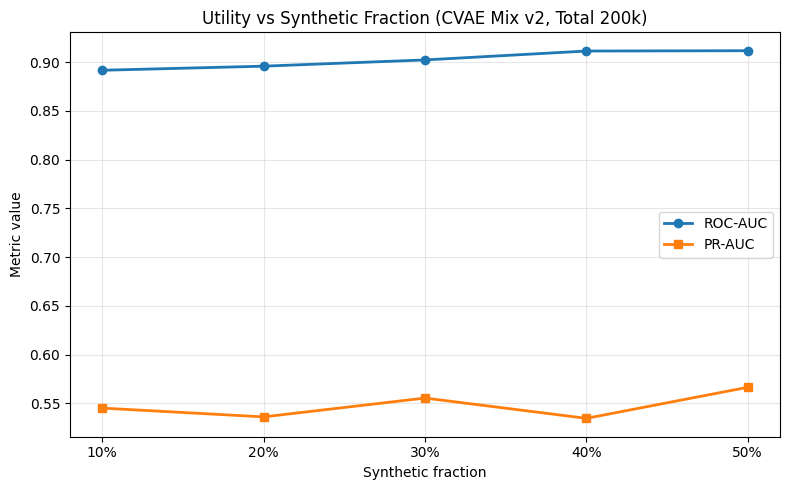

In [21]:
import matplotlib.pyplot as plt

# 1) Load the sensitivity grid results from 8.6
grid_path = "utility_cvae_mix_grid_200kv2.csv"
df_cvae_gridv2 = pd.read_csv(grid_path)

print("[8.7] Loaded CVAE mix grid results:")
print(df_cvae_gridv2)

# 2) Extract x (synthetic fraction) and y (metrics)
x = df_cvae_gridv2["syn_frac"].values
y_auc = df_cvae_gridv2["ROC-AUC"].values
y_pr  = df_cvae_gridv2["PR-AUC"].values

# 3) Plot ROC-AUC and PR-AUC as functions of synthetic fraction
plt.figure(figsize=(8, 5))

plt.plot(x, y_auc, marker="o", linewidth=2, label="ROC-AUC")
plt.plot(x, y_pr,  marker="s", linewidth=2, label="PR-AUC")

plt.title("Utility vs Synthetic Fraction (CVAE Mix v2, Total 200k)")
plt.xlabel("Synthetic fraction")
plt.ylabel("Metric value")

plt.grid(alpha=0.3)
plt.xticks(x, [f"{int(frac * 100)}%" for frac in x])
plt.legend()

plt.tight_layout()
plt.show()

Loaded df_cvae_mixed: (200000, 28)
Real data, 200k subset: (200000, 28)


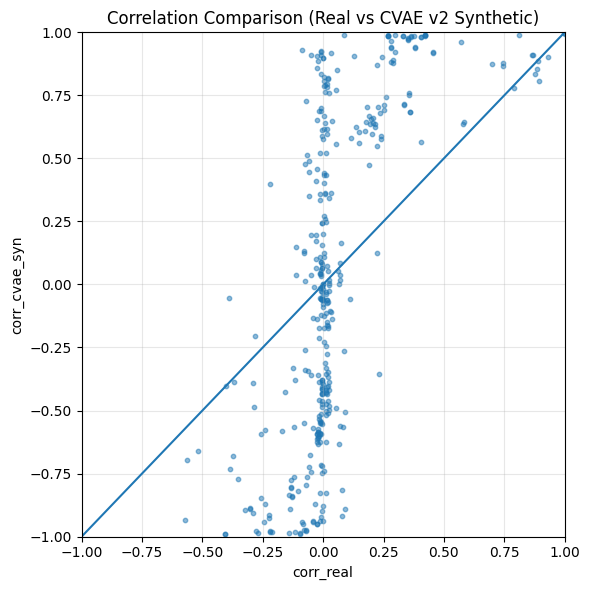

In [23]:
# 1) Load CVAE synthetic 200k
df_cvae_mixed = pd.read_parquet("synthetic/cvae_mixed_safe_top27_200k.parquet")
print("Loaded df_cvae_mixed:", df_cvae_mixed.shape)

# 2) Sample 200k real rows for a fair comparison
df_real_200k = real_data
print("Real data, 200k subset:", df_real_200k.shape)

# 3) Feature-only DataFrames
real_feats = df_real_200k.copy()
syn_feats  = df_cvae_mixed.copy()

# 4) Correlation matrices
corr_real = real_feats.corr()
corr_syn  = syn_feats.corr()

# 5) Build pairwise difference table
pairs = []
cols = real_feats.columns

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        fi = cols[i]
        fj = cols[j]
        r_real = corr_real.loc[fi, fj]
        r_syn  = corr_syn.loc[fi, fj]
        abs_diff = abs(r_real - r_syn)
        pairs.append([fi, fj, r_real, r_syn, abs_diff])

pairs_df = pd.DataFrame(pairs, columns=[
    "feat_i", "feat_j", "corr_real", "corr_syn", "abs_diff"
])

plt.figure(figsize=(6, 6))
plt.scatter(pairs_df["corr_real"], pairs_df["corr_syn"], alpha=0.5, s=10)
plt.xlabel("corr_real")
plt.ylabel("corr_cvae_syn")
plt.title("Correlation Comparison (Real vs CVAE v2 Synthetic)")

# Diagonal reference line y = x
lims = [-1, 1]
plt.plot(lims, lims)
plt.xlim(lims)
plt.ylim(lims)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Standardized real feature pool: (200000, 28)
Reference real pool shape: (100000, 28)
Probe real shape: (5000, 28)
Probe mixed  shape: (5000, 28)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



[8.9] real→real mean min distance: 0.86055535
[8.9] mixed→real mean min distance : 1.8950168


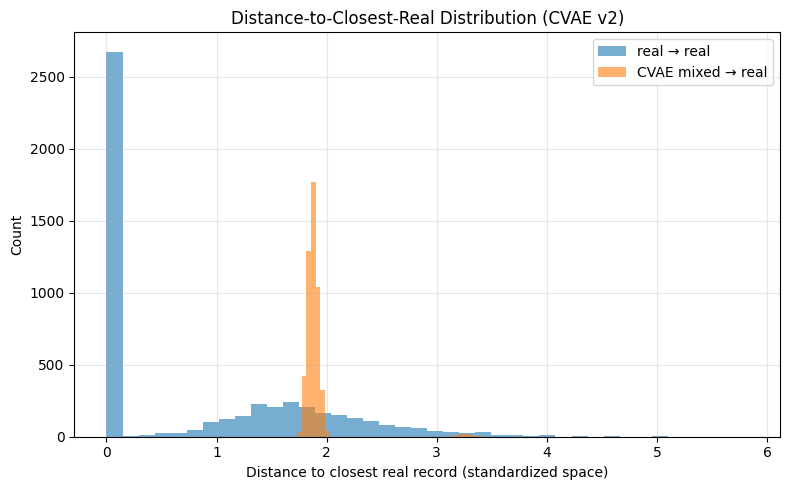

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances

# 1) Build standardized real feature pool
real_features_full = real_data.copy()

scaler_priv = StandardScaler()
real_features_std = scaler_priv.fit_transform(real_features_full)

print("Standardized real feature pool:", real_features_std.shape)

N_REF = 100000
np.random.seed(42)

ref_idx = np.random.choice(real_features_std.shape[0], size=N_REF, replace=False)
ref_real_std = real_features_std[ref_idx]

print("Reference real pool shape:", ref_real_std.shape)

N_PROBE = 5000

probe_real_idx = np.random.choice(real_features_std.shape[0], size=N_PROBE, replace=False)
probe_real_std = real_features_std[probe_real_idx]

mixed_features_std = scaler_priv.transform(df_cvae_mixed.values)

probe_mixed_idx = np.random.choice(mixed_features_std.shape[0], size=N_PROBE, replace=False)
probe_mixed_std = mixed_features_std[probe_mixed_idx]

print("Probe real shape:", probe_real_std.shape)
print("Probe mixed  shape:", probe_mixed_std.shape)

def min_dist_to_reference(probe, ref, batch_size=500):
    """
    For each row in probe, compute its distance to the nearest neighbor in ref.
    Computed in batches for memory efficiency.
    """
    n = probe.shape[0]
    min_dists = np.empty(n, dtype=np.float32)
    start = 0
    while start < n:
        end = min(start + batch_size, n)
        dists = pairwise_distances(probe[start:end], ref, metric="euclidean")
        min_dists[start:end] = dists.min(axis=1)
        start = end
    return min_dists

real_to_real_min = min_dist_to_reference(probe_real_std, ref_real_std, batch_size=500)
mixed_to_real_min  = min_dist_to_reference(probe_mixed_std,  ref_real_std, batch_size=500)

print("\n[8.9] real→real mean min distance:", real_to_real_min.mean())
print("[8.9] mixed→real mean min distance :", mixed_to_real_min.mean())

plt.figure(figsize=(8, 5))

bins = 40
plt.hist(real_to_real_min, bins=bins, alpha=0.6, label="real → real")
plt.hist(mixed_to_real_min,  bins=bins, alpha=0.6, label="CVAE mixed → real")

plt.xlabel("Distance to closest real record (standardized space)")
plt.ylabel("Count")
plt.title("Distance-to-Closest-Real Distribution (CVAE v2)")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()